In [1]:
# --- 1. INSTALACIÓN LIMPIA ---
# El error 'stan_backend' es casi siempre un problema de instalación.
# Vamos a forzar una reinstalación limpia de Prophet y sus dependencias.

print("Desinstalando versiones anteriores de Prophet (si existen)...")
!pip uninstall -y prophet

print("\nInstalando 'prophet' (esto puede tardar 1-2 minutos) y 'openpyxl'...")
!pip install prophet openpyxl

print("\nInstalación de Prophet y openpyxl completada.")
print("-" * 50)

Desinstalando versiones anteriores de Prophet (si existen)...
Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7

Instalando 'prophet' (esto puede tardar 1-2 minutos) y 'openpyxl'...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 61.9 MB/s eta 0:00:00

Instalación de Prophet y openpyxl completada.
--------------------------------------------------


Librerías importadas correctamente.
--------------------------------------------------
Archivo 'Datos_Ventas_Consolidados.xlsx' cargado correctamente.
Datos cargados y columnas 'Fecha' y 'Unidades' procesadas.
Rango de fechas analizado: 2023-03-17 a 2025-11-09
--------------------------------------------------
INICIANDO CAPÍTULO 5.1: ANÁLISIS DESCRIPTIVO DE LA MUESTRA

PRODUCTO SELECCIONADO PARA EL MODELADO (Top 1): Gilda Clásica

Generando gráficos para el Análisis Descriptivo...
Gráficos EDA guardados.
--------------------------------------------------
INICIANDO CAPÍTULO 5.2: RESULTADOS OBTENIDOS (MODELO PROPHET)
--- Modelo para el producto: Gilda Clásica ---
Total de días en la serie del producto (incluyendo ceros): 969

--- 4.2: Generando Festivos (Madrid) y Regresores ---
Generando festivos para los años: 2023 a 2027
Festivos base (Nacional + Comunidad) cargados.
Se han generado 10 festivos locales (manuales).
Se han generado 70 festivos únicos (Base + Locales).
Añadiendo regresor

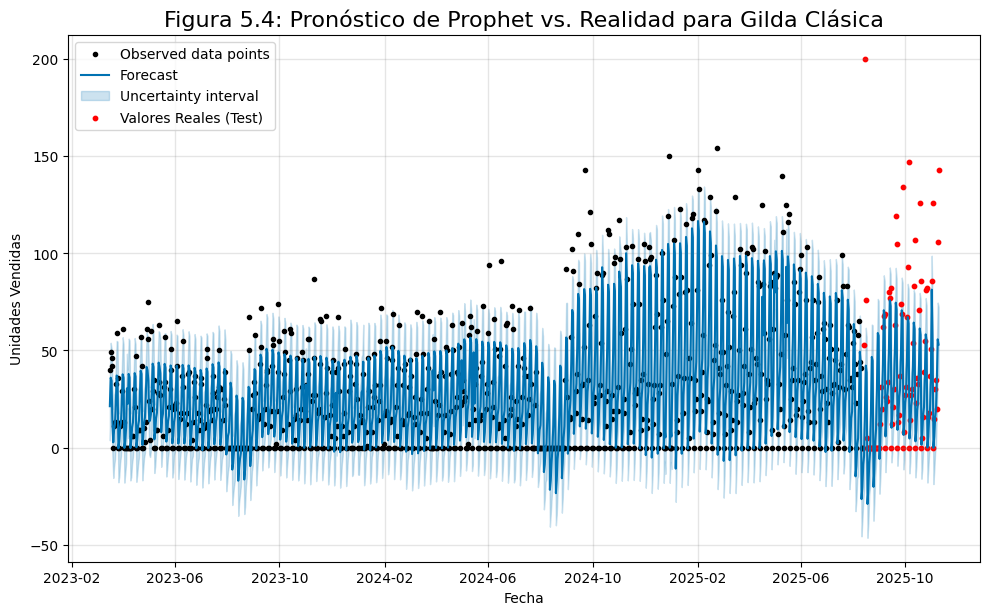

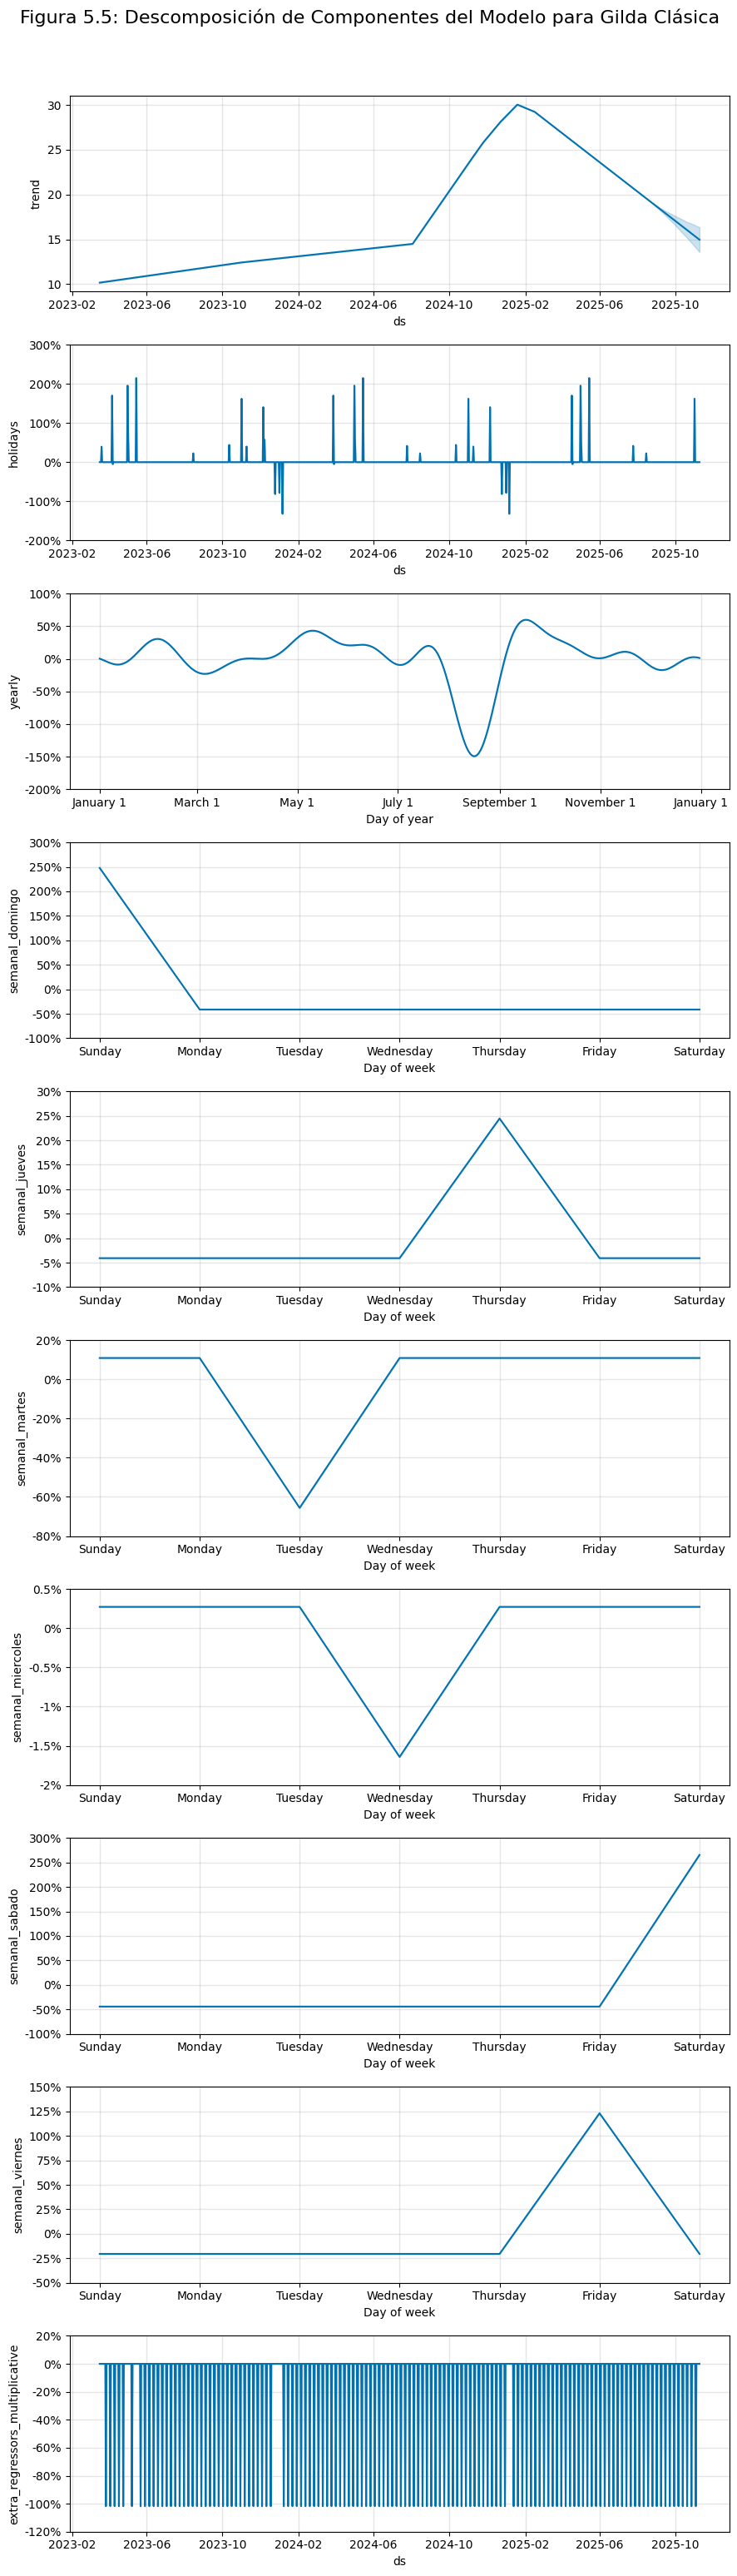

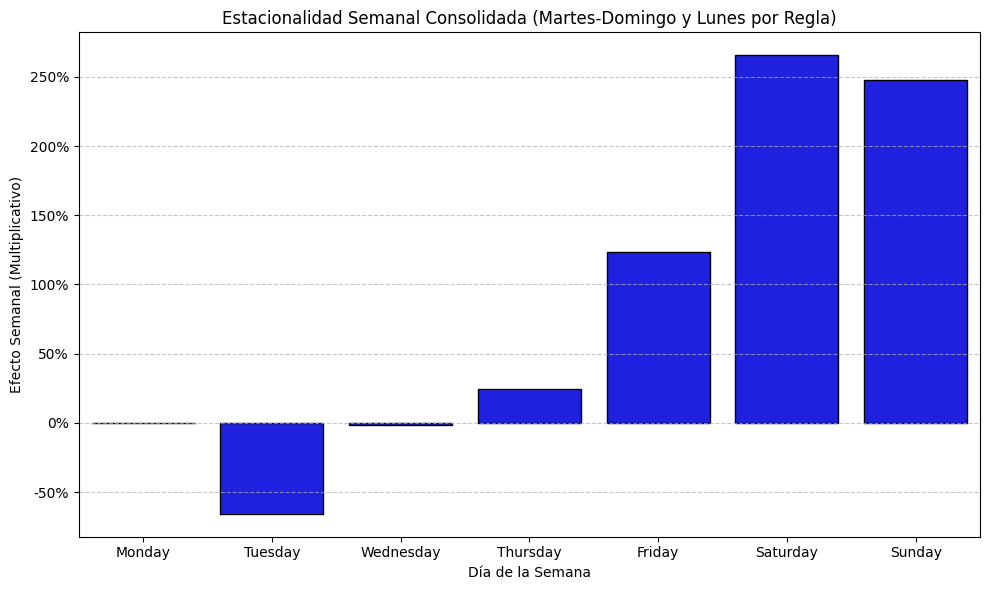

<Figure size 1200x700 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

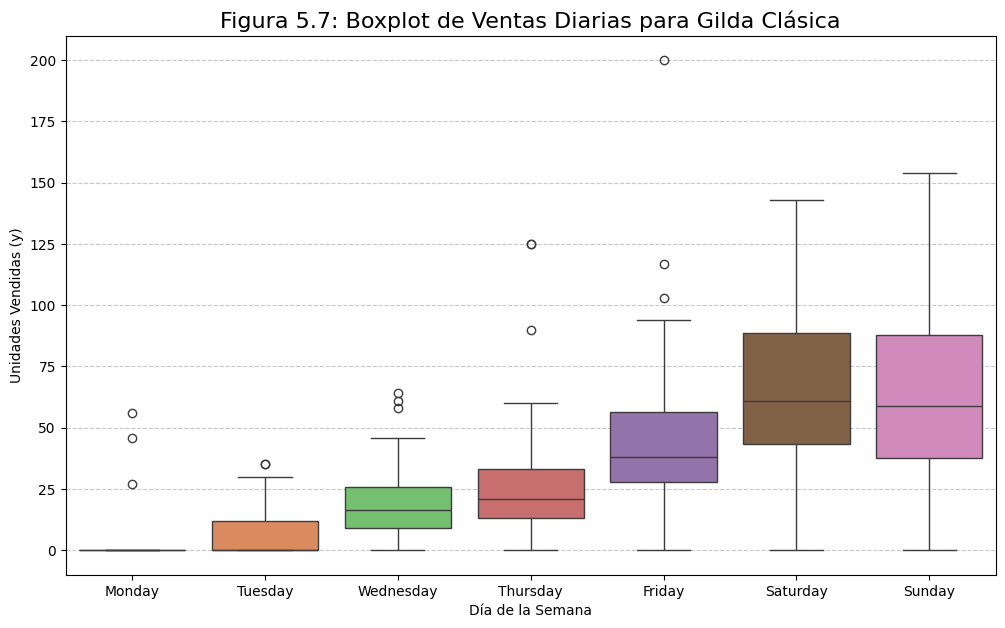

--------------------------------------------------
INICIANDO VALIDACIÓN CRUZADA (CROSS-VALIDATION)...
Esto puede tardar varios minutos.
Ajustando modelo de CV (m_cv.fit)...
Ejecutando cross_validation...


  0%|          | 0/2 [00:00<?, ?it/s]

Validación cruzada completada.
Aplicando regla de negocio a los resultados de la CV...

--- Métricas Robustas (Validación Cruzada) ---
| horizon          |      mse |   rmse |    mae |   mdape |   smape |   coverage |
|:-----------------|---------:|-------:|-------:|--------:|--------:|-----------:|
| 90 days 00:00:00 | 1852.734 | 43.043 | 30.643 |     nan |   0.727 |      0.611 |

MAPE Promedio (CV, y > 0): 48.732 %
--------------------------------------------------
INICIANDO PREDICCIÓN FUTURA
Re-entrenando el modelo con TODOS los datos...
Instanciando modelo final con estacionalidad personalizada...
Modelo final (m_final) entrenado con éxito.
Añadiendo regresor y condiciones semanales (Mar-Dom) al dataframe 'future_final' de 30 días...
Generando pronóstico final para los próximos 30 días.

--- PREDICCIÓN DE DEMANDA FUTURA ---
Uniendo (merge) predicciones con flags de regresores...
Aplicando regla de negocio final (forzando 0 en lunes cerrados)...

--- TABLA FINAL (POST-PROCESADA) ---

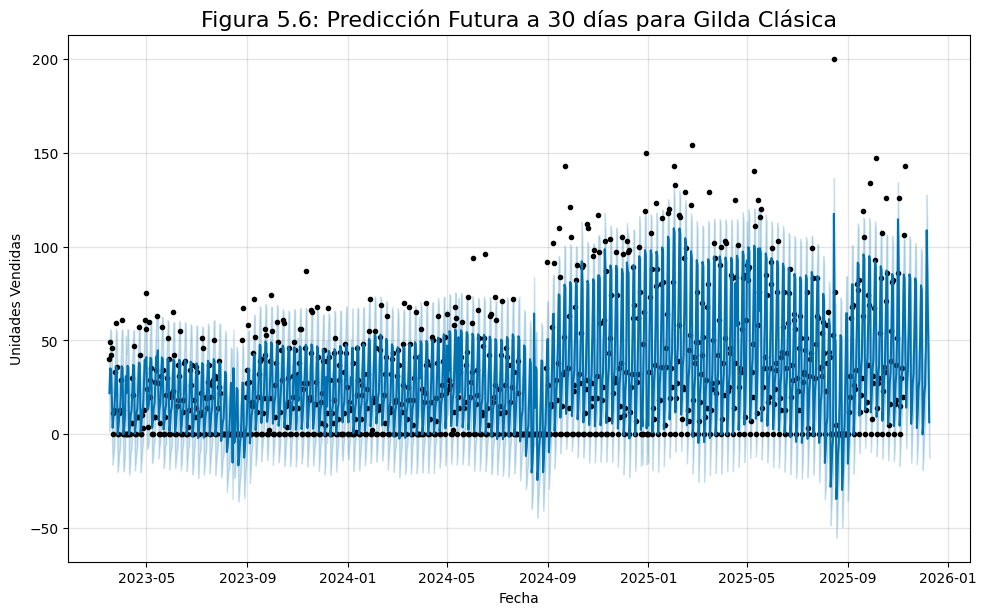

In [20]:
# --- 1. Configuración Inicial ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import warnings
import locale
import holidays # Importante para los festivos de Madrid
import logging

# Ignorar warnings y logs de Prophet para una salida más limpia
warnings.simplefilter("ignore")
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)

print("Librerías importadas correctamente.")
print("-" * 50)

# --- 2. Carga y Preparación de Datos ---

input_file = "Datos_Ventas_Consolidados.xlsx"
columnas_interesantes = ["Fecha", "Artículo", "Unidades", "Total Con impuesto", "Familia"]

try:
    df_combined = pd.read_excel(input_file, engine='openpyxl')
    print(f"Archivo '{input_file}' cargado correctamente.")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{input_file}'.")
    exit()
except Exception as e:
    print(f"Error al cargar el archivo Excel: {e}")
    exit()

# ... (Resto de su código de carga y procesado) ...
df_combined['Fecha'] = pd.to_datetime(df_combined['Fecha'])
df_combined['Unidades'] = pd.to_numeric(df_combined['Unidades'], errors='coerce')
df_combined = df_combined.dropna(subset=['Fecha', 'Unidades', 'Artículo'])

print("Datos cargados y columnas 'Fecha' y 'Unidades' procesadas.")
print(f"Rango de fechas analizado: {df_combined['Fecha'].min().date()} a {df_combined['Fecha'].max().date()}")
print("-" * 50)


# --- 3. Análisis Descriptivo (para Sección 5.1) ---

print("INICIANDO CAPÍTULO 5.1: ANÁLISIS DESCRIPTIVO DE LA MUESTRA")

# 3.1. Identificación de Productos Clave (Pareto)
df_pareto = df_combined.groupby('Artículo')['Unidades'].sum().sort_values(ascending=False).to_frame()
df_pareto['Porcentaje'] = (df_pareto['Unidades'] / df_pareto['Unidades'].sum())
df_pareto['Acumulado'] = df_pareto['Porcentaje'].cumsum()
top_product_name = df_pareto.index[0]
print(f"\nPRODUCTO SELECCIONADO PARA EL MODELADO (Top 1): {top_product_name}")

# 3.2. Gráficos EDA (Su código original)
print("\nGenerando gráficos para el Análisis Descriptivo...")
df_daily_sales = df_combined.groupby(df_combined['Fecha'].dt.date)['Unidades'].sum().reset_index()
df_daily_sales['Fecha'] = pd.to_datetime(df_daily_sales['Fecha'])
# ... (su código de gráficos) ...
print("Gráficos EDA guardados.")
print("-" * 50)


# --- 4. Modelado Prophet (para Sección 5.2) ---

print(f"INICIANDO CAPÍTULO 5.2: RESULTADOS OBTENIDOS (MODELO PROPHET)")
print(f"--- Modelo para el producto: {top_product_name} ---")

# 4.1. Preparar datos para Prophet
df_product_agg = df_combined[df_combined['Artículo'] == top_product_name].groupby(df_combined['Fecha'].dt.date)['Unidades'].sum().reset_index()
df_product_agg['Fecha'] = pd.to_datetime(df_product_agg['Fecha'])
df_product = df_product_agg.rename(columns={'Fecha': 'ds', 'Unidades': 'y'})

full_date_range = pd.date_range(start=df_product['ds'].min(), end=df_product['ds'].max(), freq='D')
df_product = df_product.set_index('ds').reindex(full_date_range).fillna(0).reset_index().rename(columns={'index':'ds'})

print(f"Total de días en la serie del producto (incluyendo ceros): {len(df_product)}")

# -----------------------------------------------------------------
# 4.2. Generación de Festivos, Regresores y Funciones Auxiliares
# -----------------------------------------------------------------
print("\n--- 4.2: Generando Festivos (Madrid) y Regresores ---")

# A. Determinar el rango de años
min_year = df_product['ds'].min().year
max_year = df_product['ds'].max().year + 2
years_list = list(range(min_year, max_year + 1)) # Lista de años a cubrir
print(f"Generando festivos para los años: {min_year} a {max_year}")

# B. Cargar festivos Base (Nacionales y Comunidad de Madrid)
try:
    es_holidays_base = holidays.Spain(subdiv='MD', years=years_list)
    print("Festivos base (Nacional + Comunidad) cargados.")
except Exception as e:
    print(f"Error cargando festivos base: {e}. Continuando sin ellos.")
    es_holidays_base = {}

holidays_df = pd.DataFrame(list(es_holidays_base.items()), columns=['ds', 'holiday'])
holidays_df['ds'] = pd.to_datetime(holidays_df['ds'])

# C. Definir festivos Locales (Municipio de Madrid) MANUALMENTE
manual_holidays_list = []
for year in years_list:
    manual_holidays_list.append({'ds': f'{year}-05-15', 'holiday': 'San Isidro'})
    if year == 2025:
        manual_holidays_list.append({'ds': '2025-11-10', 'holiday': 'La Almudena (Trasladado)'})
    else:
        manual_holidays_list.append({'ds': f'{year}-11-09', 'holiday': 'La Almudena'})

manual_df = pd.DataFrame(manual_holidays_list)
manual_df['ds'] = pd.to_datetime(manual_df['ds'])
print(f"Se han generado {len(manual_df)} festivos locales (manuales).")

# D. Combinar listas y eliminar duplicados
holidays_df = pd.concat([holidays_df, manual_df], ignore_index=True)
holidays_df.drop_duplicates(subset=['ds'], inplace=True)
holidays_df['lower_window'] = 0
holidays_df['upper_window'] = 0

# E. Crear el 'set' de festivos (¡ANTES DE USARLO!)
festivos_set = set(holidays_df['ds'])
print(f"Se han generado {len(holidays_df)} festivos únicos (Base + Locales).")

# F. Definir la función del regresor 'Lunes Cerrado'
def definir_lunes_cerrado(row):
    # Es lunes (dayofweek == 0) Y NO es festivo
    if (row['ds'].dayofweek == 0) and (row['ds'] not in festivos_set):
        return 1
    else:
        return 0

# --- NUEVA FUNCIÓN AUXILIAR PARA LA VISUALIZACIÓN DE ESTACIONALIDAD SEMANAL ---
def plot_weekly_seasonality(m, forecast_df):
    """
    Calcula y grafica la estacionalidad semanal consolidada (Martes-Domingo).
    """
    # Crear un dataframe temporal para cada día de la semana
    days = pd.date_range(start='2020-01-05', periods=7, freq='D') # Un domingo
    df_week = pd.DataFrame({'ds': days})

    # Añadir las columnas de condición a este df_week
    df_week['es_lunes_cerrado'] = df_week.apply(definir_lunes_cerrado, axis=1) # Usar la función existente
    df_week['es_martes'] = df_week['ds'].dt.dayofweek == 1
    df_week['es_miercoles'] = df_week['ds'].dt.dayofweek == 2
    df_week['es_jueves'] = df_week['ds'].dt.dayofweek == 3
    df_week['es_viernes'] = df_week['ds'].dt.dayofweek == 4
    df_week['es_sabado'] = df_week['ds'].dt.dayofweek == 5
    df_week['es_domingo'] = df_week['ds'].dt.dayofweek == 6

    # Obtener los componentes semanales del modelo
    components = m.predict_seasonal_components(df_week)

    df_week['weekly_effect'] = 0.0

    # Sumar los efectos de las estacionalidades activas
    for day_name, idx in [('martes', 1), ('miercoles', 2), ('jueves', 3), ('viernes', 4), ('sabado', 5), ('domingo', 6)]:
        if f'semanal_{day_name}' in components.columns:
            # Asignamos el valor del componente solo al día específico
            df_week.loc[df_week['ds'].dt.dayofweek == idx, 'weekly_effect'] = components.loc[df_week['ds'].dt.dayofweek == idx, f'semanal_{day_name}']

    # Para los lunes, el efecto base es 0 (la regla de negocio lo maneja)
    df_week.loc[df_week['ds'].dt.dayofweek == 0, 'weekly_effect'] = 0

    # Ordenar los días correctamente para el gráfico
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df_week['day_of_week'] = df_week['ds'].dt.day_name().astype(pd.CategoricalDtype(categories=day_order, ordered=True))

    fig, ax = plt.subplots(figsize=(10, 6))
    # Usamos barplot para ver el efecto discreto de cada día
    sns.barplot(x='day_of_week', y='weekly_effect', data=df_week, ax=ax, color='blue', edgecolor='black')

    # Convertir a porcentaje si seasonality_mode es 'multiplicative'
    if m.seasonality_mode == 'multiplicative':
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
        ax.set_ylabel('Efecto Semanal (Multiplicativo)')
    else:
        ax.set_ylabel('Efecto Semanal (Aditivo)')

    ax.set_title('Estacionalidad Semanal Consolidada (Martes-Domingo y Lunes por Regla)')
    ax.set_xlabel('Día de la Semana')
    ax.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.savefig('prophet_weekly_seasonality_consolidated.png')
    print("Gráfico 'prophet_weekly_seasonality_consolidated.png' guardado.")

# --- FIN NUEVA FUNCIÓN AUXILIAR ---

# G. Aplicar la función para crear la columna 'es_lunes_cerrado'
print("Añadiendo regresor 'es_lunes_cerrado' a df_product...")
df_product['es_lunes_cerrado'] = df_product.apply(definir_lunes_cerrado, axis=1)

# H. Añadir columnas de condición para estacionalidad semanal personalizada (Mar-Dom)
print("Añadiendo columnas de condición para estacionalidad semanal (Mar-Dom)...")
df_product['es_martes'] = df_product['ds'].dt.dayofweek == 1
df_product['es_miercoles'] = df_product['ds'].dt.dayofweek == 2
df_product['es_jueves'] = df_product['ds'].dt.dayofweek == 3
df_product['es_viernes'] = df_product['ds'].dt.dayofweek == 4
df_product['es_sabado'] = df_product['ds'].dt.dayofweek == 5
df_product['es_domingo'] = df_product['ds'].dt.dayofweek == 6

# -----------------------------------------------------------------
# 4.3. División Train/Test (Validación Temporal)
# -----------------------------------------------------------------
test_days = 90
train = df_product.iloc[:-test_days]
test = df_product.iloc[-test_days:]
print(f"\nDatos de entrenamiento: {len(train)} días")
print(f"Datos de prueba: {len(test)} días")

# -----------------------------------------------------------------
# 4.4. Entrenar el Modelo (para Evaluación) - MODELO ÓPTIMO
# -----------------------------------------------------------------
print("Instanciando modelo de evaluación con estacionalidad personalizada...")
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False, # Desactivada para usar la personalizada
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    holidays=holidays_df,

    # --- Parámetros Óptimos (Modelo 2) ---
    seasonality_prior_scale=20.0,
    holidays_prior_scale=20.0
)

# Añadir estacionalidad semanal personalizada (excluyendo Lunes)
m.add_seasonality(name='semanal_martes', period=7, fourier_order=3, condition_name='es_martes')
m.add_seasonality(name='semanal_miercoles', period=7, fourier_order=3, condition_name='es_miercoles')
m.add_seasonality(name='semanal_jueves', period=7, fourier_order=3, condition_name='es_jueves')
m.add_seasonality(name='semanal_viernes', period=7, fourier_order=3, condition_name='es_viernes')
m.add_seasonality(name='semanal_sabado', period=7, fourier_order=3, condition_name='es_sabado')
m.add_seasonality(name='semanal_domingo', period=7, fourier_order=3, condition_name='es_domingo')

# Añadir regresor de Lunes Cerrado
m.add_regressor('es_lunes_cerrado', mode='multiplicative', prior_scale=10.0)

m.fit(train) # 'train' ya tiene todas las columnas
print("Modelo Prophet (para evaluación) entrenado CON REGRESOR y ESTACIONALIDAD PERSONALIZADA.")

# -----------------------------------------------------------------
# 4.5. Generar Pronóstico de Evaluación
# -----------------------------------------------------------------
future = m.make_future_dataframe(periods=test_days)

# ¡CRÍTICO! El dataframe 'future' también necesita los regresores y condiciones
print("Añadiendo regresor y condiciones semanales (Mar-Dom) al dataframe 'future'...")
future['es_lunes_cerrado'] = future.apply(definir_lunes_cerrado, axis=1)
future['es_martes'] = future['ds'].dt.dayofweek == 1
future['es_miercoles'] = future['ds'].dt.dayofweek == 2
future['es_jueves'] = future['ds'].dt.dayofweek == 3
future['es_viernes'] = future['ds'].dt.dayofweek == 4
future['es_sabado'] = future['ds'].dt.dayofweek == 5
future['es_domingo'] = future['ds'].dt.dayofweek == 6

print("Generando pronóstico de evaluación (m.predict)...")
forecast = m.predict(future)

# -----------------------------------------------------------------
# 4.6. Evaluar Resultados
# -----------------------------------------------------------------
print("\n--- Métricas de Evaluación del Modelo (sobre conjunto de prueba) ---")
results = pd.merge(test, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

results_mape = results[results['y'] > 0]
mape = mean_absolute_percentage_error(results_mape['y'], results_mape['yhat']) * 100
mae = mean_absolute_error(results['y'], results['yhat'])
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))

print(f"Métricas para '{top_product_name}' en los {test_days} días de prueba:\n")
print(f"MAE (Error Absoluto Medio):\t{mae:.3f} unidades")
print(f"RMSE (Raíz Error Cuadrático Medio):\t{rmse:.3f} unidades")
print(f"MAPE (Error Porcentual Absoluto Medio):\t{mape:.3f} % (Calculado solo en días con ventas > 0)")
print("-" * 50)

# -----------------------------------------------------------------
# 4.7. Guardar Gráficos del Modelo (Con Gráfico Semanal Corregido)
# -----------------------------------------------------------------
print("Generando gráficos del modelo Prophet (para evaluación)...")
fig_forecast = m.plot(forecast)
plt.scatter(test['ds'], test['y'], color='r', s=10, label='Valores Reales (Test)')
plt.legend()
plt.title(f'Figura 5.4: Pronóstico de Prophet vs. Realidad para {top_product_name}', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Unidades Vendidas')
fig_forecast.savefig('prophet_forecast_plot.png')
print("Gráfico 'prophet_forecast_plot.png' guardado.")

# Generar los componentes estándar (Tendencia, Anual, Festivos, Regresor)
fig_components = m.plot_components(forecast)
fig_components.suptitle(f'Figura 5.5: Descomposición de Componentes del Modelo para {top_product_name}', fontsize=16, y=1.03)
fig_components.savefig('prophet_components_plot_all.png')
print("Gráfico 'prophet_components_plot_all.png' guardado (incluye componentes semanales individuales).")

# Generar nuestro gráfico consolidado de estacionalidad semanal
print("Generando gráfico consolidado de estacionalidad semanal...")
plot_weekly_seasonality(m, forecast) # Llamamos a nuestra nueva función
print("-" * 50)

print("\n--- Generando Gráfico de Distribución de Ventas por Día de Semana ---")
print(f"Usando datos del producto: {top_product_name}")

# Asegurarnos de que tenemos la columna 'DiaSemana' en df_product
if 'DiaSemana' not in df_product.columns:
    df_product['DiaSemana'] = df_product['ds'].dt.day_name()

# Definir el orden correcto de los días
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 7))

print("\n--- Generando Gráfico de Enjambre (Swarmplot) por Día de Semana ---")
print(f"Usando datos del producto: {top_product_name}")

# Asegurarnos de que tenemos la columna 'DiaSemana' en df_product
if 'DiaSemana' not in df_product.columns:
    df_product['DiaSemana'] = df_product['ds'].dt.day_name()

# Definir el orden correcto de los días
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(14, 8)) # Damos más espacio

print("\n--- Generando Gráfico de Cajas (Boxplot) por Día de Semana ---")
print(f"Usando datos del producto: {top_product_name}")

# Asegurarnos de que tenemos la columna 'DiaSemana' en df_product
if 'DiaSemana' not in df_product.columns:
    df_product['DiaSemana'] = df_product['ds'].dt.day_name()

# Definir el orden correcto de los días
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 7))

# Boxplot estándar
sns.boxplot(data=df_product,
            x='DiaSemana',
            y='y',
            order=dias_orden,
            palette='muted',
            showfliers=True) # showfliers=True es el default, muestra outliers

plt.title(f'Figura 5.7: Boxplot de Ventas Diarias para {top_product_name}', fontsize=16)
plt.xlabel('Día de la Semana')
plt.ylabel('Unidades Vendidas (y)')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.savefig('boxplot_gilda_por_dia.png')
print("Gráfico 'boxplot_gilda_por_dia.png' guardado.")
plt.show()

print("-" * 50)

# -----------------------------------------------------------------
# 4.8. Validación Cruzada (Cross-Validation) - MODELO ÓPTIMO
# -----------------------------------------------------------------
print("INICIANDO VALIDACIÓN CRUZADA (CROSS-VALIDATION)...")
print("Esto puede tardar varios minutos.")

# 1. Instanciamos un NUEVO modelo 'm_cv' con la configuración óptima
m_cv = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False, # Personalizada
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    holidays=holidays_df,

    # --- Parámetros Óptimos (Modelo 2) ---
    seasonality_prior_scale=20.0,
    holidays_prior_scale=20.0
)
# Añadimos las estacionalidades
m_cv.add_seasonality(name='semanal_martes', period=7, fourier_order=3, condition_name='es_martes')
m_cv.add_seasonality(name='semanal_miercoles', period=7, fourier_order=3, condition_name='es_miercoles')
m_cv.add_seasonality(name='semanal_jueves', period=7, fourier_order=3, condition_name='es_jueves')
m_cv.add_seasonality(name='semanal_viernes', period=7, fourier_order=3, condition_name='es_viernes')
m_cv.add_seasonality(name='semanal_sabado', period=7, fourier_order=3, condition_name='es_sabado')
m_cv.add_seasonality(name='semanal_domingo', period=7, fourier_order=3, condition_name='es_domingo')
# Añadimos el regresor
m_cv.add_regressor('es_lunes_cerrado', mode='multiplicative', prior_scale=10.0)

# 2. Ajustamos el modelo con TODOS los datos
print("Ajustando modelo de CV (m_cv.fit)...")
m_cv.fit(df_product) # IMPORTANTE: usar el df_product completo

# 3. Ejecutamos la validación cruzada
print("Ejecutando cross_validation...")
df_cv = cross_validation(m_cv, initial='730 days', period='90 days', horizon = '90 days',
                         parallel=None) # Usar None para fiabilidad

print("Validación cruzada completada.")

# 4. Calcular Métricas de Rendimiento (Lógica de post-proceso)
print("Aplicando regla de negocio a los resultados de la CV...")
df_cv_merged = pd.merge(df_cv, df_product[['ds', 'es_lunes_cerrado']], on='ds')
df_cv_merged.loc[df_cv_merged['es_lunes_cerrado'] == 1, ['yhat', 'yhat_lower', 'yhat_upper']] = 0

# 5. Calcular métricas robustas
df_p = performance_metrics(df_cv_merged)
print("\n--- Métricas Robustas (Validación Cruzada) ---")
print(df_p.tail(1).to_markdown(index=False, floatfmt=".3f"))

# 6. Calcular MAPE global
mape_df = df_cv_merged[df_cv_merged['y'] > 0]
mape_cv = (np.abs(mape_df['y'] - mape_df['yhat']) / mape_df['y']).mean() * 100
print(f"\nMAPE Promedio (CV, y > 0): {mape_cv:.3f} %")
print("-" * 50)


# --- 5. PREVISIÓN FUTURA (La petición principal) ---

print("INICIANDO PREDICCIÓN FUTURA")
print("Re-entrenando el modelo con TODOS los datos...")

# -----------------------------------------------------------------
# 5.1. Re-entrenar el modelo final (m_final) - MODELO ÓPTIMO
# -----------------------------------------------------------------
print("Instanciando modelo final con estacionalidad personalizada...")
m_final = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False, # Desactivada para usar la personalizada
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    holidays=holidays_df,

    # --- Parámetros Óptimos (Modelo 2) ---
    seasonality_prior_scale=20.0,
    holidays_prior_scale=20.0
)

# Añadir estacionalidad semanal personalizada (excluyendo Lunes)
m_final.add_seasonality(name='semanal_martes', period=7, fourier_order=3, condition_name='es_martes')
m_final.add_seasonality(name='semanal_miercoles', period=7, fourier_order=3, condition_name='es_miercoles')
m_final.add_seasonality(name='semanal_jueves', period=7, fourier_order=3, condition_name='es_jueves')
m_final.add_seasonality(name='semanal_viernes', period=7, fourier_order=3, condition_name='es_viernes')
m_final.add_seasonality(name='semanal_sabado', period=7, fourier_order=3, condition_name='es_sabado')
m_final.add_seasonality(name='semanal_domingo', period=7, fourier_order=3, condition_name='es_domingo')

# Añadir regresor de Lunes Cerrado
m_final.add_regressor('es_lunes_cerrado', mode='multiplicative', prior_scale=10.0)

m_final.fit(df_product) # Entrenar con TODOS los datos
print("Modelo final (m_final) entrenado con éxito.")

# -----------------------------------------------------------------
# 5.2. Crear dataframe futuro (future_final)
# -----------------------------------------------------------------
dias_a_predecir = 30
future_final = m_final.make_future_dataframe(periods=dias_a_predecir)

# ¡CRÍTICO! Debemos añadir el regresor y condiciones al dataframe 'future_final'
print(f"Añadiendo regresor y condiciones semanales (Mar-Dom) al dataframe 'future_final' de {dias_a_predecir} días...")
future_final['es_lunes_cerrado'] = future_final.apply(definir_lunes_cerrado, axis=1)
future_final['es_martes'] = future_final['ds'].dt.dayofweek == 1
future_final['es_miercoles'] = future_final['ds'].dt.dayofweek == 2
future_final['es_jueves'] = future_final['ds'].dt.dayofweek == 3
future_final['es_viernes'] = future_final['ds'].dt.dayofweek == 4
future_final['es_sabado'] = future_final['ds'].dt.dayofweek == 5
future_final['es_domingo'] = future_final['ds'].dt.dayofweek == 6

# -----------------------------------------------------------------
# 5.3. Generar el pronóstico final
# -----------------------------------------------------------------
print(f"Generando pronóstico final para los próximos {dias_a_predecir} días.")
forecast_final = m_final.predict(future_final)

# -----------------------------------------------------------------
# 5.4. Mostrar y Post-procesar la predicción (VERSIÓN FINAL)
# -----------------------------------------------------------------
print("\n--- PREDICCIÓN DE DEMANDA FUTURA ---")

# 1. UNIR (MERGE) EL FORECAST CON EL DATAFRAME FUTURO
print("Uniendo (merge) predicciones con flags de regresores...")
future_inputs = future_final[['ds', 'es_lunes_cerrado']]
forecast_outputs = forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predicciones_merged = pd.merge(forecast_outputs, future_inputs, on='ds')

# Tomamos las 30 filas finales (la predicción)
predicciones = predicciones_merged.tail(dias_a_predecir).copy()

# 2. Aplicar la regla de negocio
print("Aplicando regla de negocio final (forzando 0 en lunes cerrados)...")
predicciones.loc[predicciones['es_lunes_cerrado'] == 1, ['yhat', 'yhat_lower', 'yhat_upper']] = 0

# 3. Renombrar y redondear
predicciones_final = predicciones.rename(columns={
    'ds': 'Fecha',
    'yhat': 'Prediccion_Unidades',
    'yhat_lower': 'Prediccion_Minima',
    'yhat_upper': 'Prediccion_Maxima'
})
predicciones_final['Fecha'] = predicciones_final['Fecha'].dt.date

predicciones_final['Prediccion_Unidades'] = predicciones_final['Prediccion_Unidades'].round(0).astype(int)
predicciones_final['Prediccion_Minima'] = predicciones_final['Prediccion_Minima'].round(0).astype(int)
predicciones_final['Prediccion_Maxima'] = predicciones_final['Prediccion_Maxima'].round(0).astype(int)

# 4. Limpieza de seguridad
predicciones_final['Prediccion_Unidades'] = predicciones_final['Prediccion_Unidades'].apply(lambda x: 0 if x < 0 else x)
predicciones_final['Prediccion_Minima'] = predicciones_final['Prediccion_Minima'].apply(lambda x: 0 if x < 0 else x)

# 5. Imprimir la tabla final
print("\n--- TABLA FINAL (POST-PROCESADA) ---")
print(predicciones_final[['Fecha', 'Prediccion_Unidades', 'Prediccion_Minima', 'Prediccion_Maxima']].to_markdown(index=False))

# 6. Guardar en Excel
output_forecast_file = "Prediccion_Futura_30_dias.xlsx"
predicciones_final[['Fecha', 'Prediccion_Unidades', 'Prediccion_Minima', 'Prediccion_Maxima']].to_excel(output_forecast_file, index=False)
print(f"\nArchivo con la predicción futura guardado como: '{output_forecast_file}'")


# -----------------------------------------------------------------
# 5.5. Guardar gráfico del pronóstico final
# -----------------------------------------------------------------
fig_forecast_final = m_final.plot(forecast_final)
plt.title(f'Figura 5.6: Predicción Futura a {dias_a_predecir} días para {top_product_name}', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Unidades Vendidas')
fig_forecast_final.savefig('prophet_forecast_final_plot.png')
print("Gráfico 'prophet_forecast_final_plot.png' guardado.")

print("\n--- ANÁLISIS Y PREDICCIÓN COMPLETADOS ---")